In [5]:
require(TTR)
library(tidyverse)
library(ggplot2)
library(magrittr)
library(dplyr)

Loading required package: TTR
Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Conflicts with tidy packages ---------------------------------------------------
equals():       magrittr, testthat
filter():       dplyr, stats
is_less_than(): magrittr, testthat
is_null():      purrr, testthat
lag():          dplyr, stats
matches():      dplyr, testthat
not():          magrittr, testthat


In [3]:
pace_df <- read.csv('pace_df.csv')

sigmoid = function(x) {
    1 / (1 + exp(-x))
}

In [6]:
pace_deviation <- pace_df %>%
    dplyr::mutate(home_abs_pace_dev  = abs(pace_x - game_pace)) %>%
    dplyr::mutate(away_abs_pace_dev  = abs(pace_y - game_pace)) %>%
    dplyr::mutate(home_pace_dev      = pace_x - game_pace) %>%
    dplyr::mutate(away_pace_dev      = pace_y - game_pace) %>%
    dplyr::mutate(date               = as.Date(date)) %>%
    dplyr::mutate(year               = factor(lubridate::year(date)))

In [7]:
head(pace_deviation)

date,home_team,away_team,game_pace,pace_x,pace_y,pt_diff_x,pt_diff_y,home_abs_pace_dev,away_abs_pace_dev,home_pace_dev,away_pace_dev,year
2008-02-05,new jersey nets,los angeles lakers,92.7,86.51351,84.78378,-2.3513514,15.675676,6.186486,7.9162162,-6.186486,-7.9162162,2008
2008-02-05,philadelphia 76ers,washington wizards,92.6,88.79189,84.87568,-3.6216216,-10.621622,3.808108,7.7243243,-3.808108,-7.7243243,2008
2008-02-06,atlanta hawks,los angeles lakers,91.3,85.80541,87.86103,8.2162162,15.413022,5.494595,3.4389699,-5.494595,-3.4389699,2008
2008-02-06,dallas mavericks,milwaukee bucks,87.5,83.38108,87.38649,-5.7027027,-0.972973,4.118919,0.1135135,-4.118919,-0.1135135,2008
2008-02-06,new york knicks,indiana pacers,87.1,88.94595,94.28659,-5.3243243,-13.320700,1.845946,7.1865889,1.845946,7.1865889,2008
2008-02-06,orlando magic,new jersey nets,88.1,90.41603,88.91837,-0.9543246,-7.268222,2.316035,0.8183673,2.316035,0.8183673,2008


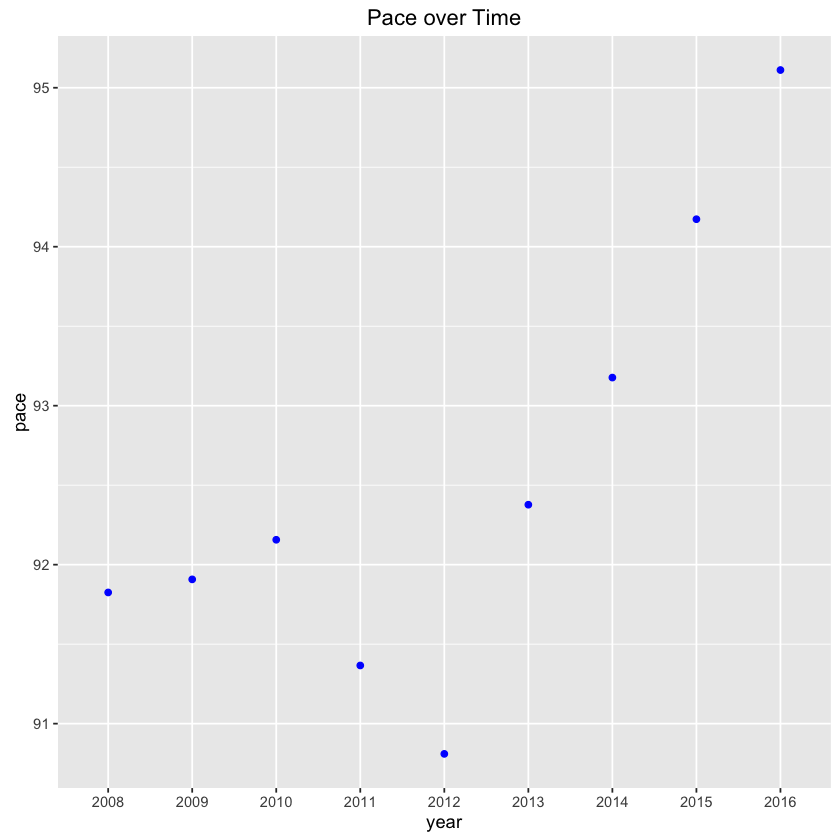

In [24]:
pace_deviation %>%
    dplyr::group_by(year) %>%
    dplyr::summarise(pace = mean(game_pace)) %>%
    ggplot(., aes(year, pace)) + geom_point(color = 'blue') +
      ggtitle('Pace over Time')

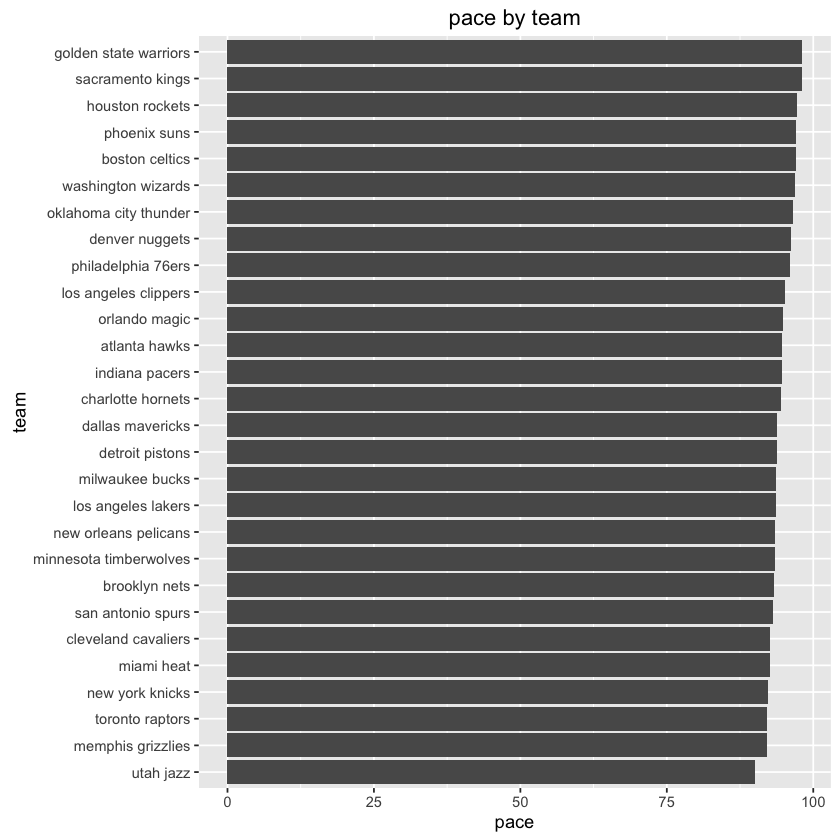

In [26]:
pace_deviation %>%
    dplyr::filter(date > '2015-01-01') %>%
    dplyr::group_by(home_team) %>%
    dplyr::summarise(pace = mean(game_pace)) %>%
    dplyr::arrange(desc(pace)) %>%
      ggplot(., aes(reorder(home_team, pace), pace)) + geom_bar(stat = 'identity') + 
        coord_flip() + xlab('team') + ggtitle('pace by team')

Warning message:
“Stacking not well defined when ymin != 0”

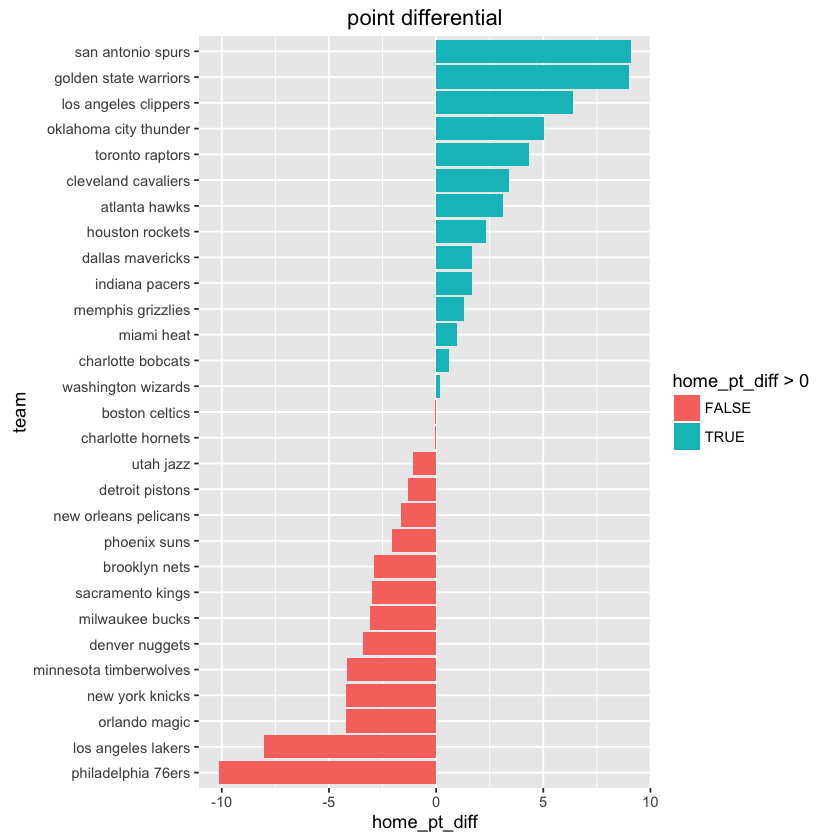

In [14]:
pace_deviation %>%
   dplyr::filter(date > '2014-01-01') %>%
   dplyr::group_by(home_team) %>%
   dplyr::summarise(home_pt_diff = mean(pt_diff_x)) %>%
   ggplot(., aes(reorder(home_team, home_pt_diff), home_pt_diff, fill = home_pt_diff > 0)) + 
     geom_bar(stat = 'identity') + coord_flip() + xlab('team') + 
     ggtitle('point differential')

does the home team have a larger effect on pace?

In [15]:
summary(lm('game_pace ~ pace_x + pace_y', data = pace_deviation))


Call:
lm(formula = "game_pace ~ pace_x + pace_y", data = pace_deviation)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.7827  -2.8283  -0.1486   2.7699  17.5393 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -35.12199    1.71491  -20.48   <2e-16 ***
pace_x        0.70062    0.01447   48.41   <2e-16 ***
pace_y        0.68047    0.01460   46.60   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.166 on 9035 degrees of freedom
Multiple R-squared:  0.3802,	Adjusted R-squared:  0.3801 
F-statistic:  2771 on 2 and 9035 DF,  p-value: < 2.2e-16


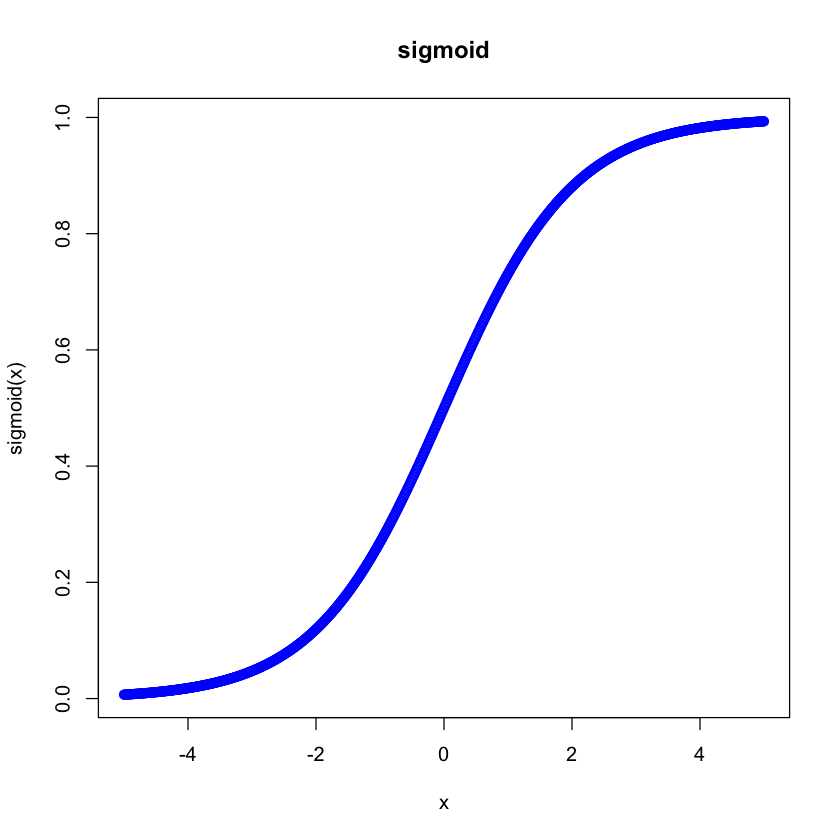

In [16]:
# explanatory purpose
x <- seq(-5, 5, 0.01)
plot(x, sigmoid(x), col = 'blue', main = 'sigmoid')

In [17]:
pace_deviation_interaction <-
    pace_deviation %>%
    dplyr::mutate(home_pt_diff_sigmoid = sigmoid(pt_diff_x),
                  away_pt_diff_sigmoid = sigmoid(pt_diff_y)) %>%
    dplyr::mutate(home_pace_mult_plusminus = pace_x * home_pt_diff_sigmoid,
                  away_pace_mult_plusminus = pace_x * away_pt_diff_sigmoid) 

**does the better team dominate pace?**


In [19]:
pace_deviation %>%
    dplyr::mutate(pt_diff_bucket = cut(pt_diff_x, seq(-5, 10, by = 3))) %>%
    dplyr::group_by(pt_diff_bucket) %>%
    dplyr::summarise(mean(home_abs_pace_dev), mean(home_pace_dev), n())

pt_diff_bucket,mean(home_abs_pace_dev),mean(home_pace_dev),n()
"(-5,-2]",3.778395,-0.05000777,1499
"(-2,1]",3.629375,-0.11107418,1680
"(1,4]",3.700043,-0.08021611,1620
"(4,7]",3.732356,-0.23985131,1280
"(7,10]",3.589190,-0.26596266,729
NA,3.792693,-0.02508518,2230


In [20]:
summary(lm('game_pace ~ home_pace_mult_plusminus + away_pace_mult_plusminus', 
           data = pace_deviation_interaction))


Call:
lm(formula = "game_pace ~ home_pace_mult_plusminus + away_pace_mult_plusminus", 
    data = pace_deviation_interaction)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.7339  -3.7099  -0.2232   3.4808  25.2174 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)              92.6102347  0.1079432 857.954  < 2e-16 ***
home_pace_mult_plusminus  0.0007325  0.0013872   0.528  0.59745    
away_pace_mult_plusminus -0.0036033  0.0013836  -2.604  0.00922 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.289 on 9035 degrees of freedom
Multiple R-squared:  0.0007854,	Adjusted R-squared:  0.0005642 
F-statistic: 3.551 on 2 and 9035 DF,  p-value: 0.02874


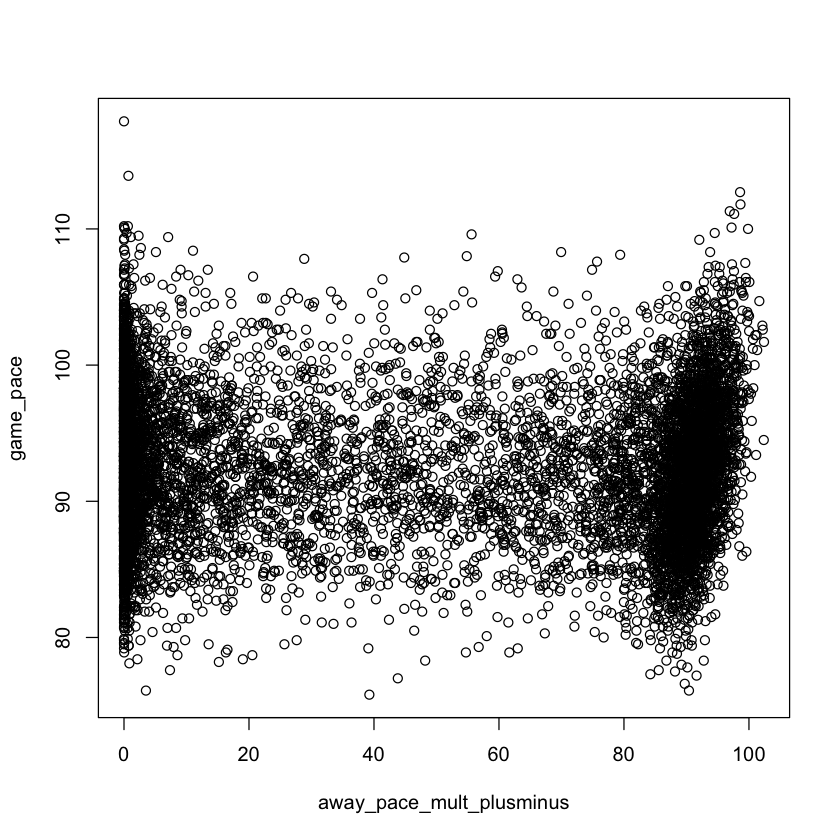

In [21]:
with(pace_deviation_interaction, plot(away_pace_mult_plusminus, game_pace))

Warning message:
“Removed 597 rows containing missing values (geom_path).”

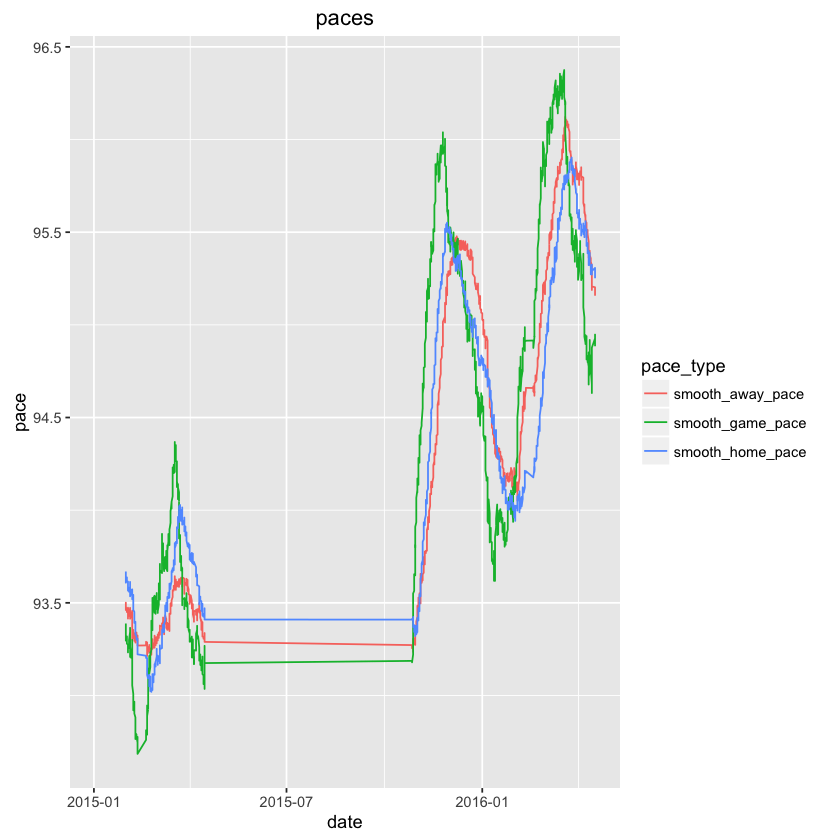

In [22]:
# SMOOTH_FACTOR observeation simple  
SMOOTH_FACTOR <- 200 
BEGIN_DATE    <- as.Date('2015-01-01')
pace_deviation %>%
    dplyr::filter(date > BEGIN_DATE) %>%
    dplyr::mutate(smooth_game_pace  = TTR::SMA(game_pace, SMOOTH_FACTOR), 
                  smooth_home_pace  = TTR::SMA(pace_x, SMOOTH_FACTOR),
                  smooth_away_pace  = TTR::SMA(pace_y, SMOOTH_FACTOR)) %>%
    dplyr::select(date, smooth_game_pace, smooth_home_pace, smooth_away_pace) %>%
    tidyr::gather(., 'pace_type', 'pace', -date) %>% 
    ggplot(., aes(date, pace, color = pace_type)) + geom_line() + 
    ggtitle('paces')